# Forecasting a Time Series

A time series consists of four parts

* trend
* seasonality
* random noise
* a stationary component (pattern with a constant mean and variance)

In [2]:
import seaborn as sns
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.ar_model import AR, AutoReg
import numpy as np

<AxesSubplot:>

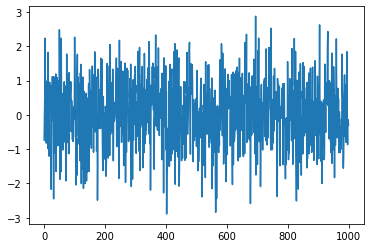

In [6]:
s = pd.Series(np.random.normal(size=1000))
s.plot()

<AxesSubplot:>

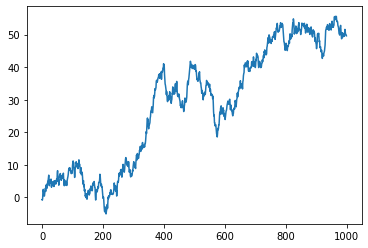

In [7]:
# add every value to the previous day --> random walk
s.cumsum().plot()

In [8]:
df = sns.load_dataset('flights')
ts = pd.to_datetime(df['month'].astype(str) + ' ' + df['year'].astype(str))
df.set_index(ts, inplace=True)
df.head()

,year,month,passengers
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121


In [10]:
# take test data from the end
train = df.iloc[:132]
test = df.iloc[132:]

<AxesSubplot:>

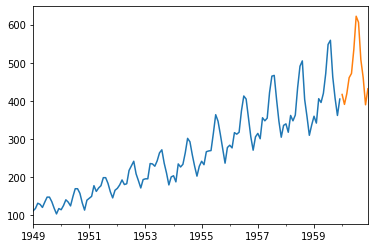

In [11]:
train['passengers'].plot()
test['passengers'].plot()

#### Technique 1: Autocorrelation

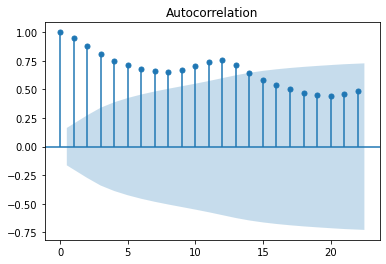

In [12]:
x = plot_acf(df['passengers']) # for 20 time lags (steps into the past)

#### Technique 2: Calculate Differences

<AxesSubplot:>

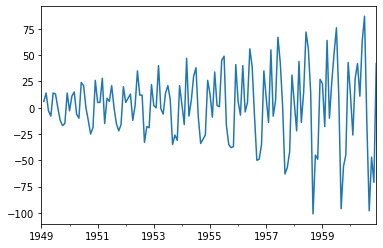

In [13]:
# subtract the previous value from every value
df['diff'] = df['passengers'].diff() # removes the trend
df['diff'].plot()

<AxesSubplot:>

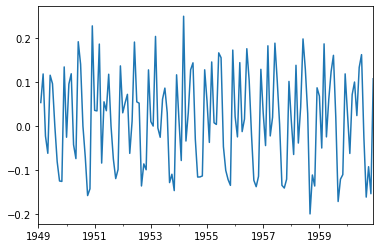

In [27]:
# calculate percent change, removes trend + change in variation
# !! ONLY WORKS FOR COUNTABLE THINGS (eggs, money, stocks, passengers, tickets)
df['pct'] = df['passengers'].pct_change() # similar to log
df['pct'].plot()

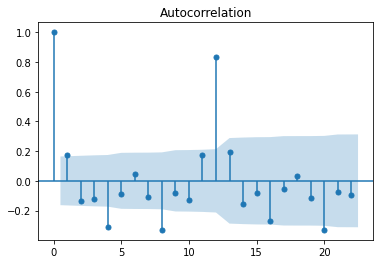

In [16]:
x = plot_acf(df['pct'].dropna())
# lots of insignificant correlations with the past
# seasonality is still in

#### Technique 3: Extract Seasonality

In [17]:
season = df.groupby('month')['pct'].mean()
season

month
Jan    0.025745
Feb   -0.010453
Mar    0.151735
Apr   -0.020056
May    0.008571
Jun    0.142526
Jul    0.121226
Aug    0.001147
Sep   -0.125067
Oct   -0.120018
Nov   -0.124927
Dec    0.132474
Name: pct, dtype: float64

<AxesSubplot:>

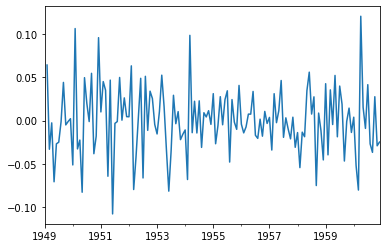

In [18]:
# remove monthly averages
df['no-season'] = df['pct'] - df['month'].replace(season)
df['no-season'].plot()  # no trend, no variation change, no seasonality

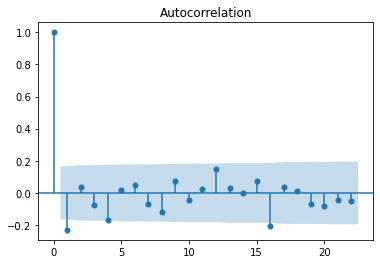

In [19]:
x = plot_acf(df['no-season'].dropna())

<AxesSubplot:>

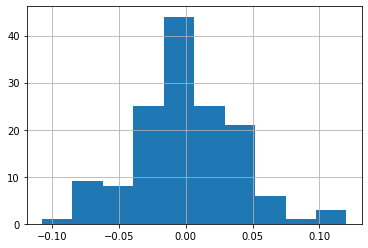

In [9]:
df['no-season'].hist()  # we end up with something close to random noise

### train an autoregressive model

Your data fluctuates around a mean but correlates locally with a few time steps in the past:

$y_t = a_1 y_{t-1} + a_2 y_{t-2} + ... + \epsilon$

**take the trend + seasonality out first**

In [23]:
y = df['passengers']
ar = AutoReg(y, lags=[1,2], trend='ct', old_names=False, seasonal=True, period=12)
result = ar.fit()
result.summary()

/home/kristian/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             passengers   No. Observations:                  144
Model:               Seas. AutoReg(2)   Log Likelihood                -583.336
Method:               Conditional MLE   S.D. of innovations             14.718
Date:                Thu, 30 Jun 2022   AIC                              5.603
Time:                        11:05:38   BIC                              5.937
Sample:                    03-01-1949   HQIC                             5.739
                         - 12-01-1960                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.3672      5.699      2.346      0.019       2.197      24.537
trend             0.8794      0.143      6.155      0.000       0.599       1.159
s(2,12)          -6.7031      6.498     -1.032      0.302     -19.440       6.033
s(3,12)          39.4541      6.695      5.893      0.000      26.332      52.576
s(4,12)          -2.3944      6.343     -0.377      0.706     -14.827      10.038
s(5,12)          16.4298      6.884      2.387      0.017       2.937      29.923
s(6,12)          49.5358      6.691      7.403      0.000      36.421      62.650
s(7,12)          49.5801      6.944      7.140      0.000      35.970      63.190
s(8,12)          21.6795      8.001      2.709      0.007       5.997      37.362
s(9,12)         -14.2685      8.757     -1.629      0.103     -31.432       2.895
s(10,12)         -1.7784      9.411     -0.189      0.850     -20.224      16.667
s(11,12)        -16.4907      7.988     -2.064      0.039     -32.147      -0.835
s(12,12)         33.7547      7.623      4.428      0.000      18.814      48.695
passengers.L1     1.0127      0.078     12.960      0.000       0.860       1.166
passengers.L2    -0.3364      0.077     -4.353      0.000      -0.488      -0.185
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5051           -0.8408j            1.7241           -0.0811
AR.2            1.5051           +0.8408j            1.7241            0.0811
-----------------------------------------------------------------------------
"""

In [24]:
predictions = ar.predict(result.params, start=len(y), end=len(y)+60-1)

/home/kristian/.local/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


<AxesSubplot:>

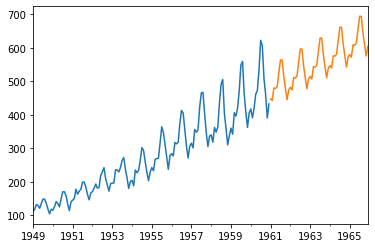

In [25]:
df['passengers'].plot()
predictions.plot()

### Improvement:

1. remove the variance change
2. build the model
3. make a prediction
4. put the variance change back in

In [38]:
y = df['pct'].dropna()
ar = AutoReg(y, lags=[1,2], trend='ct', old_names=False, seasonal=True, period=12)
result = ar.fit()
predictions = ar.predict(result.params, start=len(y), end=len(y)+160-1)

/home/kristian/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/kristian/.local/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


<AxesSubplot:>

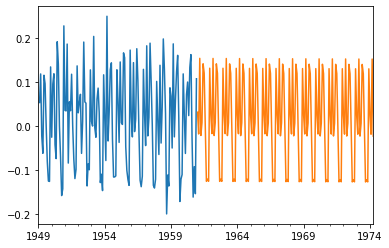

In [39]:
df['pct'].plot()
predictions.plot()

<AxesSubplot:>

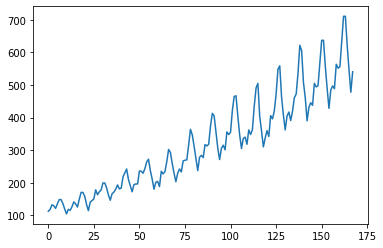

In [41]:
s = pd.Series(list(df['pct']) + list(predictions)[:24]) + 1.0
s.fillna(112).cumprod().plot()